## Evaluation 模型评估

### 一、 准备工作

In [2]:
import os

OPENAI_API_KEY = '' 
os.environ['OPENAI_API_KEY'] = '' 

from dotenv import load_dotenv

load_dotenv()

False

In [3]:
# encoding:utf-8
import os
import gradio as gr
import openai
import pinecone

from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext,PromptTemplate
from llama_index.core.schema import IndexNode
# from llama_index.llama_predictor import llama_predictor

# from langchain import OpenAI
from llama_index.core import (
    GPTKeywordTableIndex,
    SimpleDirectoryReader,
    # LLMPredictor,
    ServiceContext
)

documents = SimpleDirectoryReader(input_dir='./data').load_data()

os.environ['OPENAI_API_KEY'] = '' 

### 二、各种指标定义

1.指标1 ———— G指标

G指标：
“检查‘实际输出’中的事实是否与‘期望输出’中的任何事实相矛盾”
“你还应该严厉惩罚遗漏细节”
“含糊不清的语言或与观点相矛盾的情况是可以的”

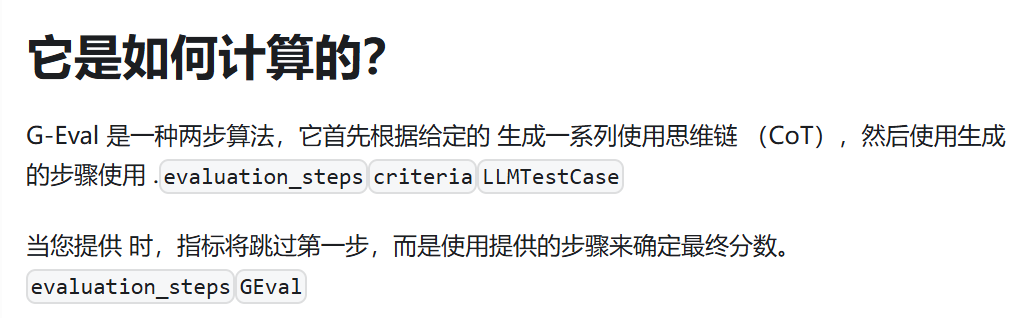

In [4]:
# 引入评估指标1：G评估

from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

correctness_metric = GEval(
    name="Correctness",
    model="gpt-3.5-turbo",
    criteria="Determine whether the actual output is factually correct based on the expected output.",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)

from deepeval.test_case import LLMTestCase

D:\Miniconda3\Lib\site-packages\deepeval\__init__.py:42: UserWarning: You are using deepeval version 0.21.40, however version 0.21.45 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


Transient error StatusCode.DEADLINE_EXCEEDED encountered while exporting traces to otlp.nr-data.net:4317, retrying in 16s.
Transient error StatusCode.DEADLINE_EXCEEDED encountered while exporting traces to otlp.nr-data.net:4317, retrying in 32s.
Transient error StatusCode.DEADLINE_EXCEEDED encountered while exporting traces to otlp.nr-data.net:4317, retrying in 1s.
Transient error StatusCode.UNAVAILABLE encountered while exporting traces to otlp.nr-data.net:4317, retrying in 32s.


2.指标2 ———— 摘要

摘要指标使用 LLM 来确定您的 LLM（应用程序）是否生成了事实正确的摘要，同时包含原始文本中的必要详细信息。

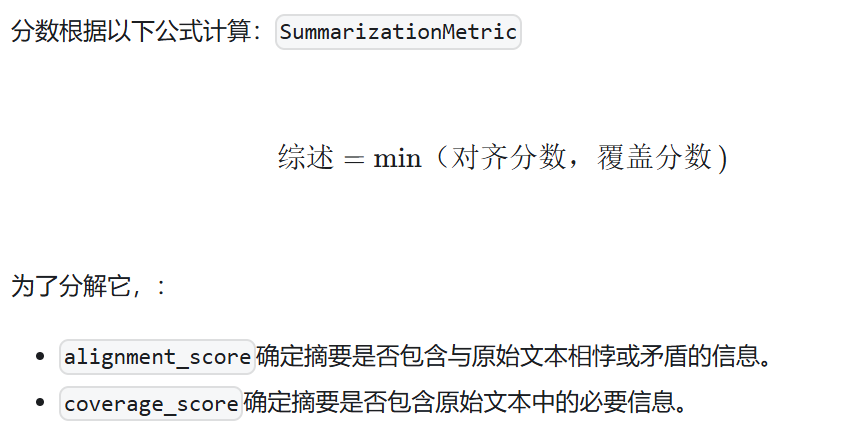

In [5]:
from deepeval import evaluate
from deepeval.metrics import SummarizationMetric
from deepeval.test_case import LLMTestCase
...

# test_case = LLMTestCase(input=input, actual_output=actual_output)
Summarization_metric = SummarizationMetric(
    threshold=0.5,
    model="gpt-3.5-turbo"
)


3.指标3 ———— 答案相关性

答案相关性指标通过评估 LLM 应用程序与提供的 .的答案相关性指标是一个自我解释的 LLM-Eval，这意味着它输出其指标分数的原因。

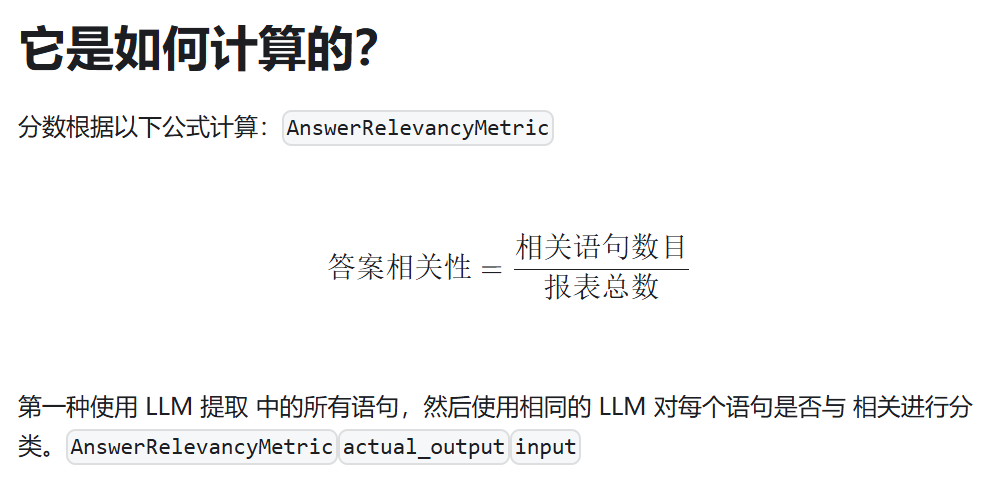

In [6]:
# 引入评估指标3：答案相关性

from deepeval import evaluate
from deepeval.metrics import AnswerRelevancyMetric
from deepeval.test_case import LLMTestCase

Relevancy_metric = AnswerRelevancyMetric(
    threshold=0.7,
    model="gpt-3.5-turbo",
    include_reason=True
)

4.指标4 ———— 上下文相关性

上下文相关性指标通过评估给定的上下文相关性指标是一个不言自明的 LLM-Eval，这意味着它输出其指标分数的原因。

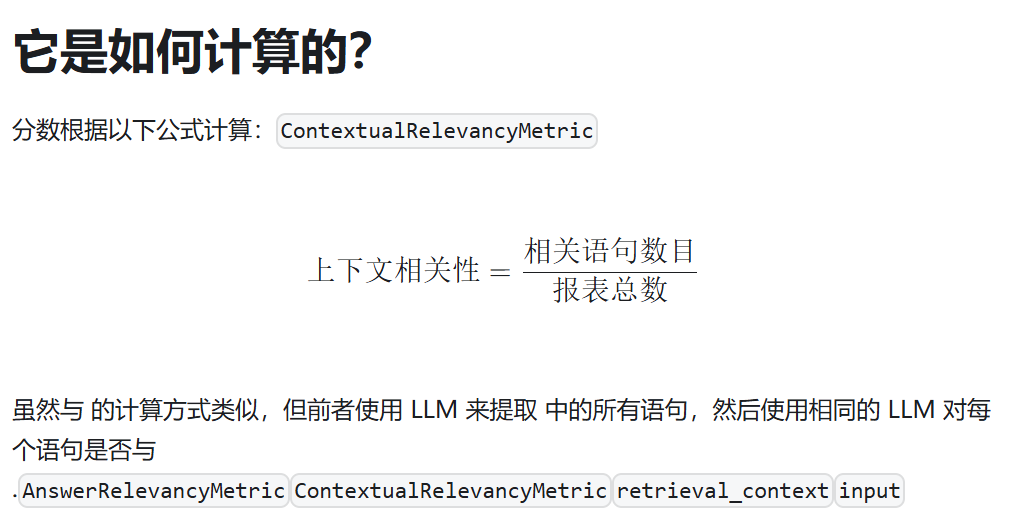

In [7]:
from deepeval import evaluate
from deepeval.metrics import ContextualRelevancyMetric
from deepeval.test_case import LLMTestCase


ContextualRelevancy_metric = ContextualRelevancyMetric(
    threshold=0.7,
    model="gpt-3.5-turbo",
    include_reason=0
)


5.指标5 ———— 幻觉

评估前后矛盾的上下文数量

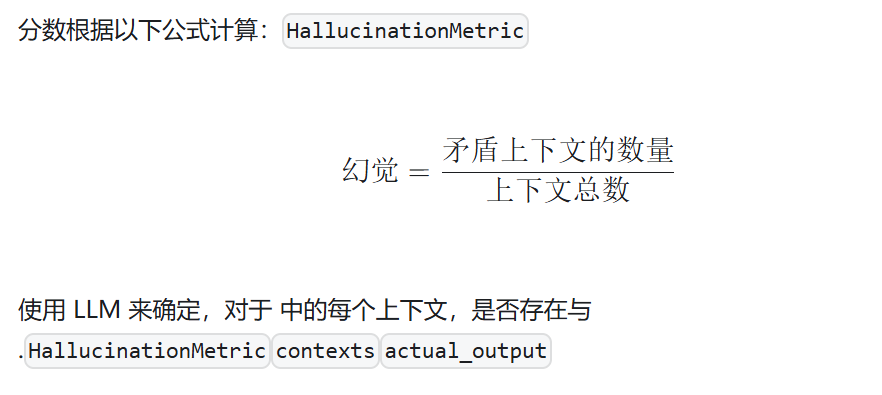

In [8]:
from deepeval import evaluate
from deepeval.metrics import HallucinationMetric
from deepeval.test_case import LLMTestCase

Hallucination_metric = HallucinationMetric(threshold=0.5,model="gpt-3.5-turbo")


### 三、模型 CustomLLM 定义、评估函数 evaluate_responses 定义

1.CustomLLM

里面可以传入不同的query_engine参数，来测试不同的模型

In [9]:
import gradio as gr
from llama_index.core import VectorStoreIndex
from langchain_openai import OpenAIEmbeddings
from deepeval.models.base_model import DeepEvalBaseLLM

# 定义自定义模型
class CustomLLM(DeepEvalBaseLLM):
    def __init__(self, query_engine):
        self.query_engine = query_engine

    def load_model(self):
        # 在这个例子中，我们不需要加载额外的模型，所以直接返回 query_engine
        return self.query_engine

    def generate(self, prompt: str) -> str:
        response = self.query_engine.query(prompt)
        return response
    
    def query(self, prompt: str) -> str:
        response = self.query_engine.query(prompt)
        return response

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)
    
    def get_model_name(self):
        return "Custom OpenAI Embedding Model"


2.评估函数



In [10]:
# 准备函数retrieval_context(nodes_r)，用来返回、拼接检索到的文档内容
def retrieval_context(nodes_r):
    context_template = " "
    context_ls = []
    for node_r in nodes_r:
        context_template = context_template + node_r.text+"\n"
        context_ls.append(node_r.text)
        
    return context_template,context_ls

In [54]:
from deepeval.metrics import ToxicityMetric
from deepeval.test_case import LLMTestCase

def evaluate_responses(model, questions, expected_outputs):
    
    assert len(questions) == len(expected_outputs), "questions 和 expected_outputs 列表长度不一致"
    
    # 调用上面矩阵来求各个评估指标
    Correctness = correctness_metric
    Summarization = Summarization_metric
    Relevancy = Relevancy_metric
    ContextualRelevancy = ContextualRelevancy_metric
    Hallucination = Hallucination_metric
    
    results = []

    for i, question in enumerate(questions):
        # 生成 response
        response = model.generate(question)
        
        # 求context内容
        retriever_base = index_OpenAIEmbeddings.as_retriever(similarity_top_k=5)
        nodes_r = retriever_base.retrieve(question)
        context,context_ls = retrieval_context(nodes_r)
        
        # 求对应 expected_output
        expected_output = expected_outputs[i]
        
        # 求各种指标
        test_case = LLMTestCase(input=question, actual_output=response, 
                                retrieval_context=context_ls, context = context_ls, 
                                expected_output=expected_output)
        Correctness.measure(test_case)
        Summarization.measure(test_case)
        Relevancy.measure(test_case)
        ContextualRelevancy.measure(test_case)
        Hallucination.measure(test_case)
    
        
            
        # 生成result
        results.append({
            'question': question,
            'response': response,
            'Correctness': Correctness.score,
            'Summarization': Summarization.score,
            'Relevancy': Relevancy.score,
            'ContextualRelevancy': ContextualRelevancy.score,
            'Hallucination': Hallucination.score,
        })
        
    return results

### 四、不同索引的建立，方便后续测试

可供调用的索引模型分别是：index_OpenAIEmbeddings   index_bge_large_zh   index_bge_M3

In [12]:
from llama_index.core import VectorStoreIndex,DocumentSummaryIndex
# from haystack.indexing.vector_store import VectorStoreIndex
from llama_index.core import KnowledgeGraphIndex
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# OpenAIEmbeddings()  
print("OpenAIEmbeddings:")
index_OpenAIEmbeddings = VectorStoreIndex.from_documents(documents = documents, StorageContext = True, embedding = OpenAIEmbeddings(), show_progress = 1)

from langchain.embeddings import HuggingFaceBgeEmbeddings

# bge-large-zh-v1.5
print("bge-large-zh-v1.5:")
bge_embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-large-zh-v1.5")
index_bge_large_zh = VectorStoreIndex.from_documents(documents = documents, embedding = bge_embeddings, show_progress = 1)

# bge-M3
print("bge-M3:")
bgeM3_embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-M3")
index_bge_M3 = VectorStoreIndex.from_documents(documents = documents, embedding = bgeM3_embeddings, show_progress = 1)

OpenAIEmbeddings:


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1277 [00:00<?, ?it/s]

bge-large-zh-v1.5:


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1277 [00:00<?, ?it/s]

bge-M3:


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1277 [00:00<?, ?it/s]

### 四、测试模型engine定义

测试阶段的整体思路：

测试一共要测试三种变量：哪种embedding、是否混合检索、是否查询重写，对这三个变量形成的组合进行5个指标的测评

（1）测试embedding

控制变量：不混合检索、不查询重写

测试：更换index_OpenAIEmbeddings、index_bge_large_zh、index_bge_M3，看指标

（2）测试混合检索

控制变量：使用index_OpenAIEmbeddings，不查询重写

测试：是否混合检索

（3）测试查询重写

控制变量：使用index_OpenAIEmbeddings，不混合检索

测试：是否查询重写

(一) 测试三种embedding

In [13]:
# 初始化模型
#########################################################################
emb1_engine = index_OpenAIEmbeddings.as_chat_engine(verbose=True)
index_OpenAIEmbeddings.storage_context

emb1_llm = CustomLLM(query_engine=emb1_engine)

###########################################################################

emb2_engine = index_bge_large_zh.as_chat_engine(verbose=True)
index_bge_large_zh.storage_context

emb2_llm = CustomLLM(query_engine=emb2_engine)

###########################################################################

emb3_engine = index_bge_M3.as_chat_engine(verbose=True)
index_bge_M3.storage_context

emb3_llm = CustomLLM(query_engine=emb3_engine)

（二）测试是否混合检索

预备代码：

In [14]:
# 假设 documents 是一个包含文档对象的列表
# 定义空的文本列表和元数据列表
doc_texts = []

# 遍历每个文档对象，获取文本内容和元数据
for i, doc in enumerate(documents):
    text = doc.text  # 假设文档对象有一个 text 属性用于获取文本内容
    if text:
        doc_texts.append(text)
    else:
        doc_texts.append("")  # 如果文本内容为空，添加一个空字符串


splitted_texts = []
# 遍历每个文本内容，按照 "http" 进行分割
for text in doc_texts:
    # 使用 split 方法按照 "http" 进行分割，并加入到分割后的文本列表中
    splitted_texts.extend(text.split("http"))

# 尝试混合检索方式
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# 将文档转换为文本列表和元数据列表
doc_metadatas = [{"source": i} for i in range(len(splitted_texts))]
print(len(splitted_texts))

# 初始化BM25检索器
bm25_retriever = BM25Retriever.from_texts(splitted_texts, metadatas = doc_metadatas)
bm25_retriever.k = 3

# 初始化FAISS检索器
embedding = OpenAIEmbeddings()
faiss_vectorstore = FAISS.from_texts(splitted_texts, embedding, metadatas=doc_metadatas)

# 将FAISS向量存储转化为检索器
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 3})

# 初始化Ensemble Retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)


1725


（三）检测是否查询重写（HyDE）

In [15]:
# Hyde查询重写的结果

from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine

query_engine = index_bge_M3.as_chat_engine(verbose=True)

### 五、调用各个模型进入评估函数

（一） 准备问题集

In [50]:
def read_questions_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        questions = file.readlines()
    return [question.strip() for question in questions]

# questions = read_questions_from_file('question/query_new_mini.txt')
questions = read_questions_from_file('question/query_new.txt')

questions

['在这次转会窗口，巴塞罗那计划如何处理财政问题以引进Amadou Onana？',
 'Karim Benzema在沙特阿拉伯遇到了哪些问题，这对他和俱乐部有何影响？',
 '曼联球员Lisandro Martinez受伤后，球队的战术和阵容发生了什么变化？',
 'Ferran Torres在比赛中向一名癌症患者致敬，这对球员和球迷有何意义？',
 '为什么Takehiro Tomiyasu在对阵West Ham United的比赛中缺席？他何时可能会重返阵容？',
 '巴塞罗那被Villarreal重创后，他们与皇马的积分差多少？这对巴萨的联赛前景有何影响？',
 'Cole Palmer在切尔西对阵水晶宫的比赛中表现出色，他提到了Mauricio Pochettino在胜利中的作用是什么？',
 '在对阵阿斯顿维拉的比赛中，切尔西的球迷建议的终极阵容是什么？',
 '在对阵托特纳姆热刺的比赛中，曼联球迷对马库斯·拉什福德的表现有什么意见？',
 '吉安路易吉·布冯表示在他职业生涯中哪个前锋对他造成了最大的痛苦？',
 '切尔西的蒂亚戈·席尔瓦在对阵水晶宫的比赛中做了什么冒险行为？',
 '2023年斯坦福桥的比赛中，哪位球员在第71分钟进球使阿斯顿维拉战胜切尔西？',
 '切尔西在2024年足总杯第三轮中以4-0战胜了哪支球队？',
 '在2024年2月初对阵埃弗顿的比赛中，阿斯顿维拉取得了什么结果？',
 '切尔西在2024年与阿斯顿维拉的比赛中，预计最有可能的比分是什么？',
 '2024年利物浦对阵阿森纳的比赛中，克洛普是否对达尔文·努涅斯不上场感到后悔？',
 '克洛普在2024年对阵阿森纳的比赛中，提到球队应该如何提高？',
 '康纳·加拉格尔在2024年对阵水晶宫的比赛中打进了多少球？',
 '康纳·加拉格尔在对阵水晶宫的比赛中，被评为比赛最佳球员后提到了什么关于主教练的战术调整？',
 '梅西、苏亚雷斯、阿尔巴和布斯克茨在2024年为哪支球队展示了他们的出色配合？']

In [51]:
expected_output = [
    "巴塞罗那计划通过出售一些球员来筹集资金，可能会将Frenkie De Jong和Ronald Araujo列入出售名单，以便购买Amadou Onana。",
    "Karim Benzema与Al Ittihad的主教练Marcelo Gallardo发生了冲突，这可能对他在俱乐部的未来产生影响，并可能影响球队的氛围和战绩。",
    "Lisandro Martinez受伤后，曼联可能需要调整他们的防守组织和中场配置，可能会影响他们在比赛中的表现和战术风格。",
    "Ferran Torres的这个举动展现了他的人道主义精神和对球迷的关怀，这可能会赢得更多球迷的支持和尊重，同时也为球迷带来了温暖和鼓舞。",
    "Takehiro Tomiyasu因为国家队比赛后出现了小伤，所以缺席了比赛。目前尚不清楚他何时可以重返阵容，但希望他的伤势只是轻微的问题。",
    "巴塞罗那在主场被Villarreal以5-3击败，导致他们与皇马的积分差距达到了10分。这对巴萨本赛季的联赛前景造成了不小的影响，使得他们的冠军希望受到挑战。",
    "Cole Palmer提到了Mauricio Pochettino在胜利中的作用，称赞了他的指导和支持，认为Pochettino对球队的凝聚力和信心给予了很大的帮助。这表明了Pochettino在切尔西的作用和影响。",
    "Petrovic；迪萨西、蒂亚戈·席尔瓦、巴迪亚希尔；奇尔维尔、凯塞多、恩佐、古斯托；帕尔默、杰克逊、恩昆库。",
    "尽管拉什福德打入一球，但有一部分球迷对他的表现不满意，认为他决策糟糕，影响了球队进攻。有球迷甚至呼吁曼联在夏季将他出售。",
    "布冯表示是克里斯蒂亚诺·罗纳尔多，总是能在比赛中攻破他的球门，尤其是2018年欧冠四分之一决赛中的倒钩进球。",
    "蒂亚戈·席尔瓦冒着受伤的风险，封堵了马特塔的一次射门，但在此过程中脚踝扭伤，被利维·科尔威尔替换下场。",
    "奥利·沃特金斯 (Ollie Watkins)",
    "普雷斯顿北区 (Preston North End)",
    "平局",
    "1-1",
    "克洛普表示他不会改变首发阵容，但在比赛后可能会有不同的想法。",
    "克洛普认为球队需要踢得更好，并在接下来的比赛中展现出更好的足球水平。",
    "两个",
    "主教练在中场休息时改变了球队在对方半场的结构，使球队在下半场创造了更多机会。",
    "迈阿密国际"
]

（二）测试embedding

In [ ]:
results_emb1 = evaluate_responses(emb1_llm, questions, expected_output)
print(len(results_emb1))

In [ ]:
results_emb2 = evaluate_responses(emb2_llm, questions, expected_output)

In [ ]:
results_emb3 = evaluate_responses(emb3_llm, questions, expected_output)

In [61]:
import csv

filepath_emb1 = "evaluate_output/embedding_eva/emb1.csv"
filepath_emb2 = "evaluate_output/embedding_eva/emb2.csv"
filepath_emb3 = "evaluate_output/embedding_eva/emb3.csv"

fieldnames = ['Question', 'Response', 'Correctness', 'Summarization','Relevancy','ContextualRelevancy',"Hallucination"]

def write_outcome(filepath,results):
    with open(filepath, mode='w', newline='') as file:
        writer = csv.DictWriter(file,fieldnames)
        
        # 写入表头
        writer.writeheader()
        
        print(len(results))
        # 遍历结果列表，逐行写入数据
        for result in results:
            writer.writerow({'Question': result['question'],
                            'Response': result['response'],
                            'Correctness': result['Correctness'],
                            'Summarization': result['Summarization'],
                            'Relevancy': result['Relevancy'],
                            'ContextualRelevancy': result['ContextualRelevancy'],
                            'Hallucination': result['Hallucination']})

    print(f"Results written to {filepath}")
    
write_outcome(filepath_emb1,results_emb1)
write_outcome(filepath_emb2,results_emb2)
write_outcome(filepath_emb3,results_emb3)

20
Results written to evaluate_output/embedding_eva/emb1.csv
20
Results written to evaluate_output/embedding_eva/emb2.csv
9
Results written to evaluate_output/embedding_eva/emb3.csv


In [87]:
def get_mean(results):
    
    correctness_values = [result['Correctness'] for result in results]
    summarization_values = [result['Summarization'] for result in results]
    relevancy_values = [result['Relevancy'] for result in results]
    contextual_relevancy_values = [result['ContextualRelevancy'] for result in results]
    hallucination_values = [result['Hallucination'] for result in results]
    
    # 计算均值
    correctness_mean = sum(correctness_values) / len(correctness_values)
    summarization_mean = sum(summarization_values) / len(summarization_values)
    relevancy_mean = sum(relevancy_values) / len(relevancy_values)
    contextual_relevancy_mean = sum(contextual_relevancy_values) / len(contextual_relevancy_values)
    hallucination_mean = sum(hallucination_values) / len(hallucination_values)

    # 返回均值
    mean_values = {
        'Correctness': correctness_mean,
        # 'Summarization': summarization_mean,
        'Relevancy': relevancy_mean,
        'ContextualRelevancy': contextual_relevancy_mean,
        'Hallucination': hallucination_mean
    }
    
    return mean_values

print("results_emb1:")
mean_emb1 = get_mean(results_emb1)
print(get_mean(results_emb1))

print("results_emb2:")
mean_emb2 = get_mean(results_emb2)
print(get_mean(results_emb2))

print("results_emb3:")
mean_emb3 = get_mean(results_emb3)
print(get_mean(results_emb3))


results_emb1:
{'Correctness': 0.7699292935231512, 'Relevancy': 0.9650000000000001, 'ContextualRelevancy': 0.14, 'Hallucination': 0.9828571428571429}
results_emb2:
{'Correctness': 0.7234596724793214, 'Relevancy': 0.9025000000000001, 'ContextualRelevancy': 0.16000000000000003, 'Hallucination': 0.89}
results_emb3:
{'Correctness': 0.7402808995251274, 'Relevancy': 0.8148148148148148, 'ContextualRelevancy': 0.2222222222222222, 'Hallucination': 0.9444444444444444}


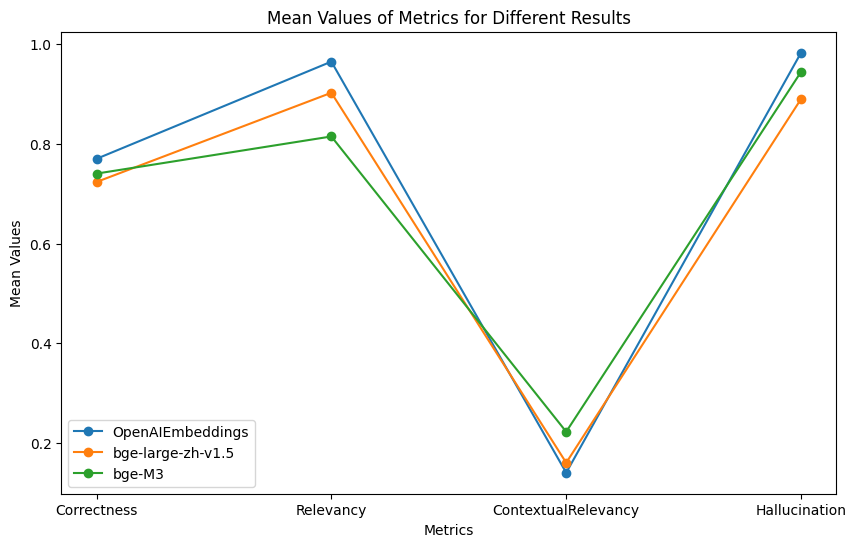

In [94]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.figure(figsize=(10, 6))

# 定义指标
metrics = list(mean_emb1.keys())

# 绘制各条线
plt.plot(metrics, list(mean_emb1.values()), marker='o', label='OpenAIEmbeddings')
plt.plot(metrics, list(mean_emb2.values()), marker='o', label='bge-large-zh-v1.5')
plt.plot(metrics, list(mean_emb3.values()), marker='o', label='bge-M3')

# 设置图例和标签
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('Mean Values of Metrics for Different Results')
plt.legend()

# 显示图形
plt.show()

三、测试混合检索

In [ ]:
from deepeval.metrics import ToxicityMetric
from deepeval.test_case import LLMTestCase

def evaluate_responses(model, questions, expected_outputs):
    
    assert len(questions) == len(expected_outputs), "questions 和 expected_outputs 列表长度不一致"
    
    # 调用上面矩阵来求各个评估指标
    Correctness = correctness_metric
    Summarization = Summarization_metric
    Relevancy = Relevancy_metric
    ContextualRelevancy = ContextualRelevancy_metric
    Hallucination = Hallucination_metric
    
    results = []

    for i, question in enumerate(questions):
        # 生成 response
        response = model.generate(question)
        
        # 求context内容
        retriever_base = index_OpenAIEmbeddings.as_retriever(similarity_top_k=5)
        nodes_r = retriever_base.retrieve(question)
        context,context_ls = retrieval_context(nodes_r)
        
        # 求对应 expected_output
        expected_output = expected_outputs[i]
        
        # 求各种指标
        test_case = LLMTestCase(input=question, actual_output=response, 
                                retrieval_context=context_ls, context = context_ls, 
                                expected_output=expected_output)
        Correctness.measure(test_case)
        Summarization.measure(test_case)
        Relevancy.measure(test_case)
        ContextualRelevancy.measure(test_case)
        Hallucination.measure(test_case)
    
        
            
        # 生成result
        results.append({
            'question': question,
            'response': response,
            'Correctness': Correctness.score,
            'Summarization': Summarization.score,
            'Relevancy': Relevancy.score,
            'ContextualRelevancy': ContextualRelevancy.score,
            'Hallucination': Hallucination.score,
        })
        
    return results

In [64]:
def evaluate_responses_ensemble(model, questions, ensemble_retriever,expected_outputs):
    
    assert len(questions) == len(expected_outputs), "questions 和 expected_outputs 列表长度不一致"
    
    # 调用上面矩阵来求各个评估指标
    Correctness = correctness_metric
    Summarization = Summarization_metric
    Relevancy = Relevancy_metric
    ContextualRelevancy = ContextualRelevancy_metric
    Hallucination = Hallucination_metric
    
    results = []

    for i, question in enumerate(questions):
        
        # 使用Ensemble Retriever进行检索
        docs = ensemble_retriever.invoke(question)  # 使用问题而不是硬编码的query
        
        # 将相关文档内容组合成一个字符串，传递给query_engine
        doc_contents = "\n".join([doc.page_content for doc in docs])
        combined_query = f"我的问题是：{question}。我已知下面这些信息：{doc_contents}。请你根据这些内容回答。"
        
        # 使用query_engine进行总结和回答
        response = model.generate(combined_query)
        
        # 求context内容
        context_ls = []
        
        docs = ensemble_retriever.invoke(question)
        for doc in docs:
            context_ls.append(doc.page_content)
   
        # 求对应 expected_output
        expected_output = expected_outputs[i]
        
        # 求各种指标（这里省略您原先的代码，直接将计算指标的部分放在这里）
        # 求各种指标
        test_case = LLMTestCase(input=question, actual_output=response, 
                                retrieval_context=context_ls, context = context_ls, 
                                expected_output=expected_output)
        
        Correctness.measure(test_case)
        Summarization.measure(test_case)
        Relevancy.measure(test_case)
        ContextualRelevancy.measure(test_case)
        Hallucination.measure(test_case)
        
        # 生成result
        results.append({
            'question': question,
            'response': response,
            'Correctness': Correctness.score,
            'Summarization': Summarization.score,
            'Relevancy': Relevancy.score,
            'ContextualRelevancy': ContextualRelevancy.score,
            'Hallucination': Hallucination.score,
        })
        
    return results


In [ ]:
result_ensemble = evaluate_responses_ensemble(emb1_llm, questions, ensemble_retriever, expected_output)

In [89]:
print(result_ensemble)

[{'question': '在这次转会窗口，巴塞罗那计划如何处理财政问题以引进Amadou Onana？', 'response': Response(response='根据查询结果，巴塞罗那计划处理财政问题以引进Amadou Onana的方法是考虑签约预算选项，寻找价格较低的质量球员。这种方法使他们有可能在不超出财务限制的情况下引进球员，如Amadou Onana。以下是一些预算转会选项，巴塞罗那可以考虑作为下一个签约对象：Aboubakary Koita（毛里塔尼亚）、Logan Costa（佛得角）、Lamine Camara（塞内加尔）和Kamory Doumbia（马里）。埃弗顿的Amadou Onana的价格标签为50万欧元，这一高估值可能会对巴塞罗那构成挑战，因为他们倾向于寻找市场上更便宜的选项以遵守财务公平竞赛规则。巴塞罗那的策略是通过签约较低费用或自由球员来签约球员，正如他们之前签约的Oriol Romeu（320万欧元）、Ilkay Gundogan和Inigo Martinez等自由球员。Amadou Onana的显著价格标签可能会使巴塞罗那难以追求他，考虑到他们的财务限制和对经济实惠签约的偏好。尽管Oriol Romeu请求离开，但巴塞罗那不会让他离开，因为他们目前面临着九名一线队球员受伤的困境。这一障碍，加上有限的时间和财力找到替代球员，阻止了巴塞罗那允许Romeu离开。', source_nodes=[NodeWithScore(node=TextNode(id_='2b906730-a2dd-4ecf-a94c-a27d3e4696aa', embedding=None, metadata={'file_path': 'c:\\Users\\Thinkpad\\Desktop\\项目大作业——基于 LLM 和 RAG 的足球新闻检索系统\\data\\data.csv', 'file_name': 'data.csv', 'file_type': 'application/vnd.ms-excel', 'file_size': 3953400, 'creation_date': '2024-04-12', 'last_modified_date': '2024-05-09'}, excluded_embed_metadata_key

In [67]:
filepath_ensemble = "evaluate_output/ensemble_eva/ensemble.csv"

fieldnames = ['Question', 'Response', 'Correctness', 'Summarization','Relevancy','ContextualRelevancy',"Hallucination"]

def write_outcome(filepath,results):
    with open(filepath, mode='w', newline='') as file:
        writer = csv.DictWriter(file,fieldnames)
        
        # 写入表头
        writer.writeheader()
        
        print(len(results))
        # 遍历结果列表，逐行写入数据
        for result in results:
            writer.writerow({'Question': result['question'],
                            'Response': result['response'],
                            'Correctness': result['Correctness'],
                            'Summarization': result['Summarization'],
                            'Relevancy': result['Relevancy'],
                            'ContextualRelevancy': result['ContextualRelevancy'],
                            'Hallucination': result['Hallucination']})

    print(f"Results written to {filepath}")
    
write_outcome(filepath_ensemble,result_ensemble)

20
Results written to evaluate_output/ensemble_eva/ensemble.csv


In [68]:
print("result_ensemble:")
mean_ensemble = get_mean(result_ensemble)
print(get_mean(result_ensemble))

result_ensemble:
{'Correctness': 0.6528374506104946, 'Relevancy': 0.76, 'ContextualRelevancy': 0.155, 'Hallucination': 0.8800000000000001}


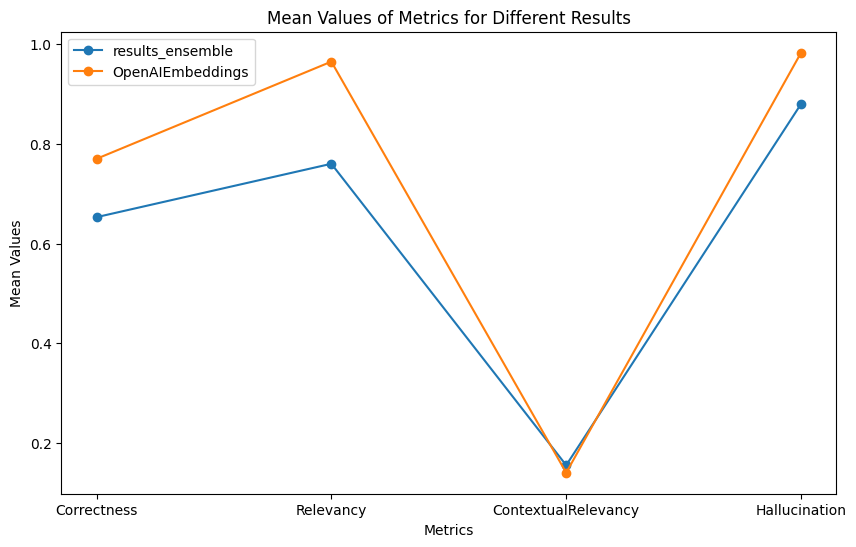

In [95]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.figure(figsize=(10, 6))

# 定义指标
metrics = list(mean_ensemble.keys())

# 绘制各条线
plt.plot(metrics, list(mean_ensemble.values()), marker='o', label='results_ensemble')
plt.plot(metrics, list(mean_emb1.values()), marker='o', label='OpenAIEmbeddings')


# 设置图例和标签
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('Mean Values of Metrics for Different Results')
plt.legend()

# 显示图形
plt.show()

### 四、测试查询重写

（一）预备代码

In [73]:
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine

def evaluate_responses_hyde(model, questions, expected_outputs):
    
    Correctness = correctness_metric
    Summarization = Summarization_metric
    Relevancy = Relevancy_metric
    ContextualRelevancy = ContextualRelevancy_metric
    Hallucination = Hallucination_metric
    
    results = []
    
    query_engine = index_OpenAIEmbeddings.as_chat_engine(verbose=True)
    hyde = HyDEQueryTransform(include_original=True)
    hyde_query_engine = TransformQueryEngine(query_engine, hyde)
    
    for i, question in enumerate(questions):
        
        response = hyde_query_engine.query(question)
        
        # 求context内容
        retriever_base = index_OpenAIEmbeddings.as_retriever(similarity_top_k=4)
        nodes_r = retriever_base.retrieve(question)
        context,context_ls = retrieval_context(nodes_r)
        
        # 求对应 expected_output
        expected_output = expected_outputs[i]
        
        # 求各种指标
        test_case = LLMTestCase(input=question, actual_output=response, 
                                retrieval_context=context_ls, context = context_ls, 
                                expected_output=expected_output)
        Correctness.measure(test_case)
        Summarization.measure(test_case)
        Relevancy.measure(test_case)
        ContextualRelevancy.measure(test_case)
        Hallucination.measure(test_case)
        
        # 生成result
        results.append({
            'question': question,
            'response': response,
            'Correctness': Correctness.score,
            'Summarization': Summarization.score,
            'Relevancy': Relevancy.score,
            'ContextualRelevancy': ContextualRelevancy.score,
            'Hallucination': Hallucination.score,
        })
        
    return results

In [77]:
result_hyde = evaluate_responses_hyde(emb1_llm, questions,expected_output)

Retrying llama_index.llms.openai.base.OpenAI._chat in 0.6091210601050329 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.
Retrying llama_index.llms.openai.base.OpenAI._chat in 0.018062855919336984 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.
Retrying llama_index.llms.openai.base.OpenAI._chat in 3.311644334141458 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You 

KeyboardInterrupt: 

In [72]:
filepath_hyde = "evaluate_output/HyDE/hyde.csv"

fieldnames = ['Question', 'Response', 'Correctness', 'Summarization','Relevancy','ContextualRelevancy',"Hallucination"]

def write_outcome(filepath,results):
    with open(filepath, mode='w', newline='') as file:
        writer = csv.DictWriter(file,fieldnames)
        
        # 写入表头
        writer.writeheader()
        
        print(len(results))
        # 遍历结果列表，逐行写入数据
        for result in results:
            writer.writerow({'Question': result['question'],
                            'Response': result['response'],
                            'Correctness': result['Correctness'],
                            'Summarization': result['Summarization'],
                            'Relevancy': result['Relevancy'],
                            'ContextualRelevancy': result['ContextualRelevancy'],
                            'Hallucination': result['Hallucination']})

    print(f"Results written to {filepath}")
    
write_outcome(filepath_hyde,result_hyde)

9
Results written to evaluate_output/HyDE/hyde.csv


In [90]:
print("result_hyde:")
mean_hyde = get_mean(result_hyde)
print(get_mean(result_hyde))

result_hyde:
{'Correctness': 0.6877464855067571, 'Relevancy': 1.0, 'ContextualRelevancy': 0.2777777777777778, 'Hallucination': 0.9619047619047618}


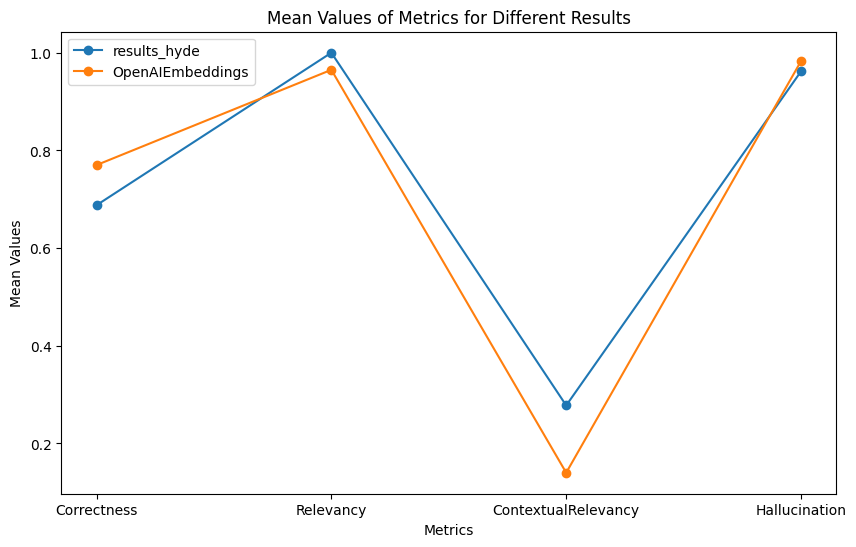

In [96]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.figure(figsize=(10, 6))

# 定义指标
metrics = list(mean_hyde.keys())

# 绘制各条线
plt.plot(metrics, list(mean_hyde.values()), marker='o', label='results_hyde')
plt.plot(metrics, list(mean_emb1.values()), marker='o', label='OpenAIEmbeddings')

# 设置图例和标签
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('Mean Values of Metrics for Different Results')
plt.legend()

# 显示图形
plt.show()

### 整体效果图

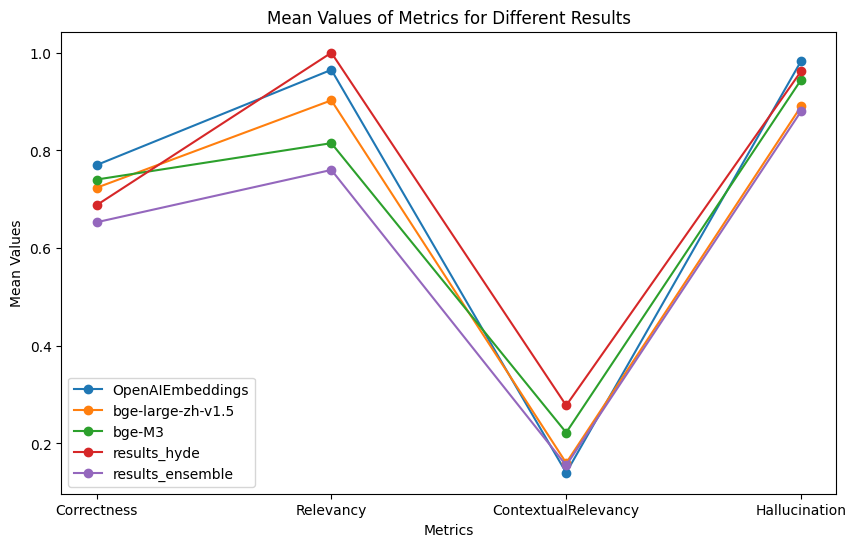

In [97]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.figure(figsize=(10, 6))

# 定义指标
metrics = list(mean_hyde.keys())

# 绘制各条线

plt.plot(metrics, list(mean_emb1.values()), marker='o', label='OpenAIEmbeddings')
plt.plot(metrics, list(mean_emb2.values()), marker='o', label='bge-large-zh-v1.5')
plt.plot(metrics, list(mean_emb3.values()), marker='o', label='bge-M3')
plt.plot(metrics, list(mean_hyde.values()), marker='o', label='results_hyde')
plt.plot(metrics, list(mean_ensemble.values()), marker='o', label='results_ensemble')

# 设置图例和标签
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('Mean Values of Metrics for Different Results')
plt.legend()

# 显示图形
plt.show()